In [1]:
import json
from functools import lru_cache
from typing import List

import pandas as pd
import requests
from haversine import haversine
from pydantic import BaseModel, conint, confloat
from ratelimit import RateLimitException, limits
from tenacity import *
from yarl import URL

from secrets import APP_ID, APP_KEY


def get_id_key():
    return {"app_id": APP_ID, "app_key": APP_KEY}

In [2]:
@retry(
    wait=wait_exponential(max=60, min=1),
    stop=stop_after_attempt(3),
)
@retry(
    retry=retry_if_exception_type(RateLimitException),
    wait=wait_fixed(1),
    stop=stop_after_delay(60),
)
@limits(calls=500, period=60)
def call_get(url: URL) -> str:
    """
    Make a generic call to the TfL API. This function handles rate limits and retries,
    as well as ensuring that the API call has the app_id and app_key appended to the
    call.

    :param url: URL to make a GET request on for the TfL API
    :return: decoded string of response
    """
    return requests.get(url.update_query(get_id_key())).text

In [3]:
API_ENDPOINT = URL("https://api.tfl.gov.uk/")


@lru_cache()
def tube_line_ids() -> List[str]:
    """
    Get a list of all tube line ids, these can then be used to call endpoints
    of "Line" / line_id for line_id in this list; after the first call this data
    is cached in memory.

    :return: list of string line_ids e.g. "victoria"
    """
    return [
        item["id"]
        for item in json.loads(
            call_get(API_ENDPOINT / "Line" / "Mode" / "tube" / "Route")
        )
    ]

tube_line_ids()

['bakerloo',
 'central',
 'circle',
 'district',
 'hammersmith-city',
 'jubilee',
 'metropolitan',
 'northern',
 'piccadilly',
 'victoria',
 'waterloo-city']

In [4]:
class LineStopPointInfo(BaseModel):
    name: str
    distance: confloat(ge=0)  # from the centre of London, (51.509865, -0.118092)
    connections: conint(ge=0)

In [34]:
def parse_result(result) -> LineStopPointInfo:
    """
    Apply our domain-specific parsing logic to an element of the /Line/line_id/StopPoints
    TfL API call, where line_id is the id of a tube line e.g. "victoria".

    :param result: dictionary representing a single result
    :return: parsed LineStopPointInfo objects
    """
    return LineStopPointInfo(
        name=result["commonName"],
        distance=haversine((51.509865, -0.118092), (result["lat"], result["lon"])),
        connections=len(
            [
                item["id"]
                for item in result.get("lines", [])
                if item["id"] in tube_line_ids()
            ]
        ) - 1,  # one result is always for the given line,
    )

In [35]:
def line_stop_points(line_id: str) -> List[LineStopPointInfo]:
    """
    For a give tube line, get a list of stop points, and apply domain-specific parsing logic to get
    a list of LineStopPointInfo objects.

    :param line_id: string line id e.g. "victoria"
    :return: list of parsed LineStopPointInfo objects
    """
    return [
        parse_result(result)
        for result in json.loads(
            call_get(API_ENDPOINT / "Line" / line_id / "StopPoints")
        )
    ]

In [36]:
def line_stop_df(line_id: str) -> pd.DataFrame:
    """
    For a given tube line, get the results of line_stop_points and convert into a pandas DataFrame
    with columns name, distance (from the centre of London) and (number of) connections.

    :param line_id: string line id e.g. "victoria"
    :return: parsed DataFrame with columns name, distance and connections
    """
    return pd.DataFrame([item.dict() for item in line_stop_points(line_id)])

In [37]:
df = pd.concat([line_stop_df(line) for line in tube_line_ids()])

In [38]:
df.sample(10)

,connections,distance,name
6,5,2.339422,King's Cross St. Pancras Underground Station
13,0,6.681326,Clapham South Underground Station
7,0,15.903542,Kenton Underground Station
10,0,25.965326,Epping Underground Station
37,0,13.706469,Richmond Underground Station
0,1,2.974545,Aldgate Underground Station
6,1,12.149533,East Ham Underground Station
11,0,13.892075,Kingsbury Underground Station
48,0,11.307997,West Acton Underground Station
13,0,2.715412,Vauxhall Underground Station


In [39]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [40]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,6)})

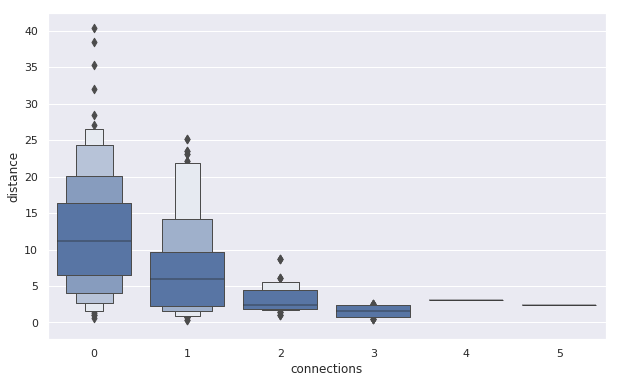

In [41]:
plot = sns.boxenplot(
    x="connections",
    y="distance",
    color="b", 
    scale="linear",
    data=df,
)

In [42]:
plot.figure.savefig('figure.png')